In this notebook, we compare the data-scaling of different learning algorithms
on CIFAR-10 (and SVHN... we ended up doing everything in this notebook).

Many of the cells are create paper-ready figures.

The methods we compare are:
1. Random guessing
2. Training a DNN from scratch. (Bahri et al., Rosenfeld et al.)
3. Linear probe on top of a pretrained model. (CLIP, LAION CLIP)
4. Finetuning a pretrained model.

### Load libraries

In [1]:
import os
import pathlib
import sys
from typing import Any, Optional, Type

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import stylesheets, utils
from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10
from src.pretrain.models import BaseEmbedderConfig, get_embedder_index

transformers.logging.set_verbosity_error()

# Load wandb data

### Probe data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "cifar10"}},
        ]
    },
)


def get_df_from_run(
    run_id: str,
    run_config: dict[str, Any],
    run_summary: dict[str, Any],
) -> pd.DataFrame:
    api = wandb.Api(timeout=30)
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run_id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run_config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run_config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run_summary["embed_dim"]
    ret_df["n_embedder_params"] = run_summary["n_embedder_params"]
    ret_df["seed"] = run_config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


dfs = process_map(
    get_df_from_run,
    [r.id for r in runs],
    [dict(r.config) for r in runs],
    [
        {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
        for r in runs
    ],
    max_workers=14,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df["loss"] = df["xent"]
df

  0%|          | 0/500 [00:00<?, ?it/s]

,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,err_3,err_4,err_5,err_6,err_7,err_8,err_9,model,model_type,loss
0,0.01,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi,inf
1,1.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi,inf
2,100.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi,inf
3,NaN,NaN,49,True,0.1826,NaN,2,False,knn,0,...,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi,NaN
4,0.01,10000.0,49,True,0.1826,inf,2,False,linear,0,...,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211495,NaN,NaN,0,True,0.9832,NaN,5000,True,knn,0,...,0.059,0.017,0.015,0.005,0.008,0.002,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit,NaN
211496,NaN,NaN,0,True,0.9819,NaN,5000,True,knn,0,...,0.061,0.018,0.015,0.005,0.007,0.002,0.016,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit,NaN
211497,0.01,10000.0,0,True,0.9870,0.073968,5000,True,linear,0,...,0.025,0.012,0.032,0.010,0.006,0.006,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit,0.073968
211498,1.00,10000.0,0,True,0.9858,inf,5000,True,linear,0,...,0.030,0.014,0.033,0.011,0.004,0.008,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit,inf


### Finetuning data

In [3]:
def parse_finetune_runs(
    runs: list[wandb.apis.public.Run],
) -> pd.DataFrame:
    df = (
        utils.runs_to_df(runs)
        .query("state == 'finished'")
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    df["test_err"] = 1 - df.test_acc
    df["val_err"] = 1 - df.val_acc_max
    df["train_err"] = 1 - df.train_acc_max

    df["val_loss"] = df.val_loss_min
    df["train_loss"] = df.train_loss_min
    return df


api = wandb.Api()

df_finetune = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/finetune",
        filters={"tags": {"$in": ["finetune-sweep-v1.4"]}},
    )
)
print(len(df_finetune))

df_finetune_old = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/transfer",
        filters={"tags": {"$in": ["clip-cifar-finetune"]}},
    )
)
print(len(df_finetune_old))

df_probe_scaling = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/finetune",
        filters={"tags": {"$in": ["probe-scaling-v1"]}},
    )
)
df_probe_scaling = df_probe_scaling.query(
    "~("
    + "&".join(
        (
            f"embedder_cfg_id == 'openai/ViT-L/14'",
            f"n_layers_to_freeze != 30",
        )
    )
    + ")"
)
print(len(df_probe_scaling))

df_finetune_freeze = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/finetune",
        filters={"tags": {"$in": ["finetune-sweep-freeze-v1"]}},
    )
)
print(len(df_finetune_freeze))


60
66
130
380


### Load transcribed data from papers

In [4]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/cifar10/wpd-clean.csv")
df_bahri["loss"] = df_bahri.xent

df_prune_scratch = pd.read_csv(
    GIT_ROOT / "data/sorscher-2022/cifar10/scratch/wpd-clean.csv"
)
df_prune_scratch["err"] = df_prune_scratch.errp / 100

df_prune_transfer = pd.read_csv(
    GIT_ROOT / "data/sorscher-2022/cifar10/transfer/wpd-clean.csv"
)

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

# Plots

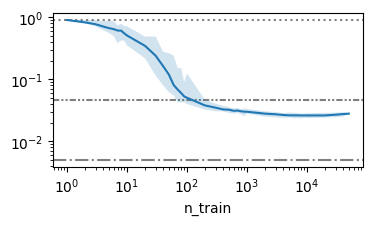

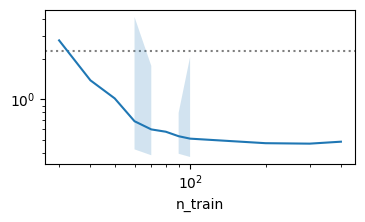

In [5]:
def plot_wandb_df(
    df: pd.DataFrame,
    query: str,
    target: str = "err",
    ci: float = 1,
    gb_target: str = "n_train",
    dataset_id: str = "cifar10",
    **kwargs,
):
    gb = df.query(
        "&".join(
            (
                "dataset_id == @dataset_id",
                "cls_start == 0",
                "cls_end == 10",
                "(c == 100 | k == 1)",
                query,
            )
        )
    ).groupby([gb_target])

    ax = gb[target].median().plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    return dict(ax=ax, gb=gb)


def plot_baselines(
    target: str = "err",
    include_labels: bool = True,
    include_citation: bool = False,
    label_prefix: str = "",
):
    plt.axhline(
        {"err": 0.9, "loss": np.log(10)}[target],
        color="k",
        linestyle=":",
        label=label_prefix + r"Random guessing: $90\%$"
        if include_labels
        else None,
        zorder=-10,
        alpha=0.5,
    )

    if target != "err":
        return
    # Human accuracy
    # Karpathy gives 94% (http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/)
    # https://arxiv.org/abs/1811.07270 gives 93.91 \pm 1.52%
    # We'll give an upper bound of 93.91 + 1.52 = 95.43%
    plt.axhline(
        1 - 0.9543,
        color="k",
        linestyle=(0, (3, 1, 1, 1, 1, 1)),
        label=(
            label_prefix
            + r"Human performance: $4.57\%$, \citet{ho2018cifar10}"
            if include_citation
            else r"Human performance: $4.57\%$"
        )
        if include_labels
        else None,
        zorder=-10,
        alpha=0.5,
    )

    # https://paperswithcode.com/sota/image-classification-on-cifar-10
    plt.axhline(
        1 - 0.995,
        color="k",
        linestyle="-.",
        label=label_prefix + r"SOTA: $0.05\%$, paperswithcode (2023-02-02)"
        if include_labels
        else None,
        zorder=-10,
        alpha=0.5,
    )


for target in ["err", "loss"]:
    plt.figure(figsize=(4, 2))
    embedder_id = "openai/ViT-L/14"
    plot_baselines(target=target)
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        target=target,
    )
    plt.xscale("log")
    plt.yscale("log")


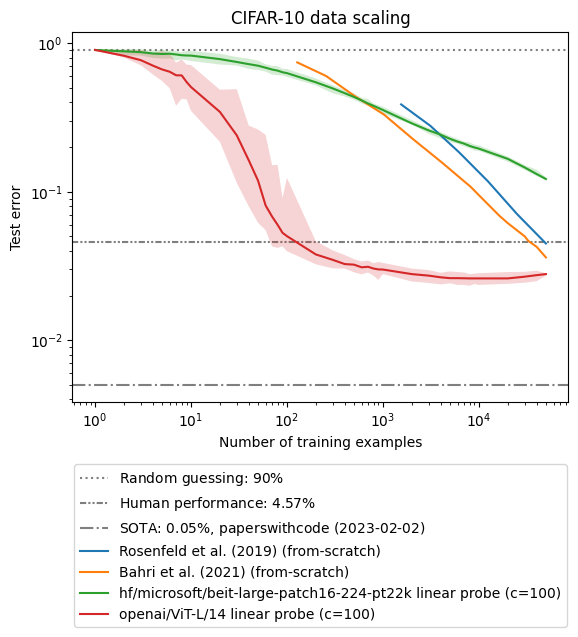

In [6]:
plot_baselines()
plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
# plt.plot(
#     df_prune_scratch.n_train,
#     df_prune_scratch.err,
#     label="Sorscher et al. (2022) (from-scratch + data-pruning)",
#     linestyle="--",
# )

for embedder_id in (
    "hf/microsoft/beit-large-patch16-224-pt22k",
    "openai/ViT-L/14",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )

plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

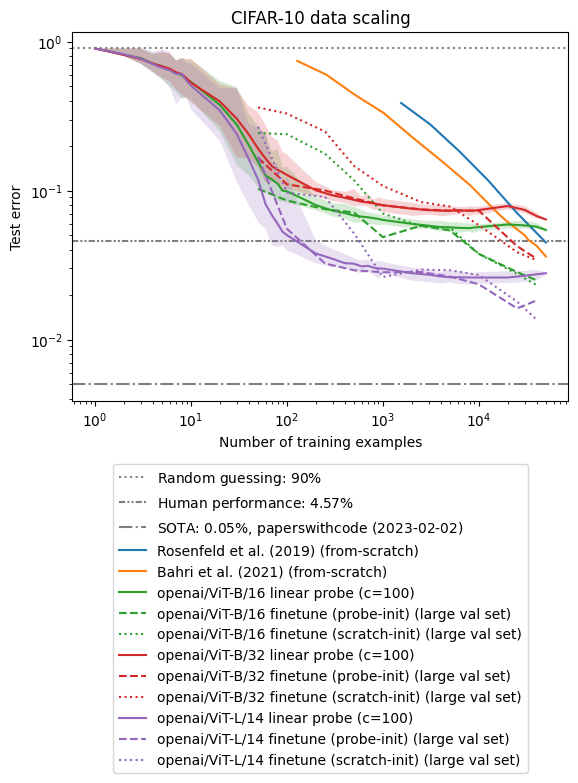

In [7]:
plot_baselines()
plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

for embedder_id in (
    # "hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
    # "hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
    "openai/ViT-B/16",
    "openai/ViT-B/32",
    "openai/ViT-L/14",
    # "openai/ViT-L/14@336px",
):
    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )["ax"]
    prev_color = ax.lines[-1].get_color()

    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle="--",
        color=prev_color,
        label=f"{embedder_id} finetune (probe-init) (large val set)",
    )

    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "~init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle=":",
        color=prev_color,
        label=f"{embedder_id} finetune (scratch-init) (large val set)",
    )

# cdf = df_finetune_old.query(f"weight_decay == 0")
# plt.plot(
#     cdf.n_train,
#     cdf.test_err,
#     label=f"openai/ViT-L/14 OLD finetune",
#     linestyle="--",
#     zorder=-10,
# )

plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
# plt.yscale("symlog", linthresh=9e-3)
# plt.ylim(-1e-3, 1.1)
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

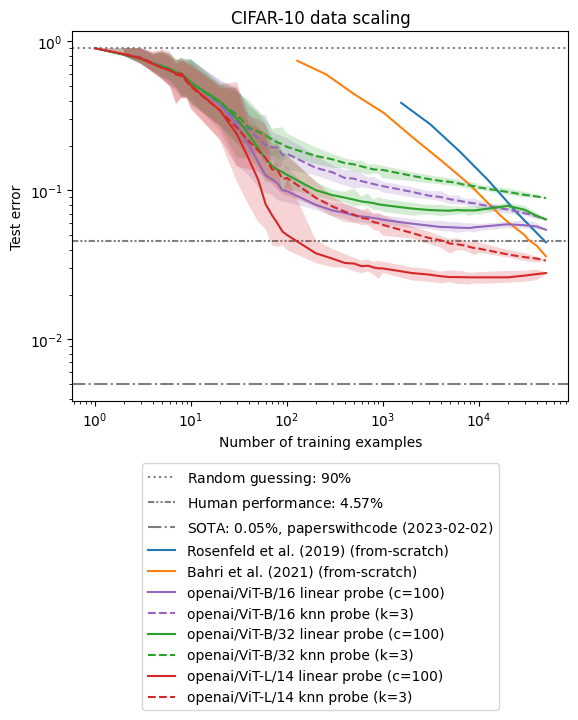

In [8]:
plot_baselines()
plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

colors = ["tab:purple", "tab:green", "tab:red"]
for embedder_id, color in zip(
    [
        "openai/ViT-B/16",
        "openai/ViT-B/32",
        "openai/ViT-L/14",
    ],
    colors,
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
        color=color
    )["ax"]

    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=f"{embedder_id} knn probe (k=3)",
        linestyle="--",
        color=color,
    )

plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
# plt.yscale("symlog", linthresh=9e-3)
# plt.ylim(-1e-3, 1.1)
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()


### Study different types of probes

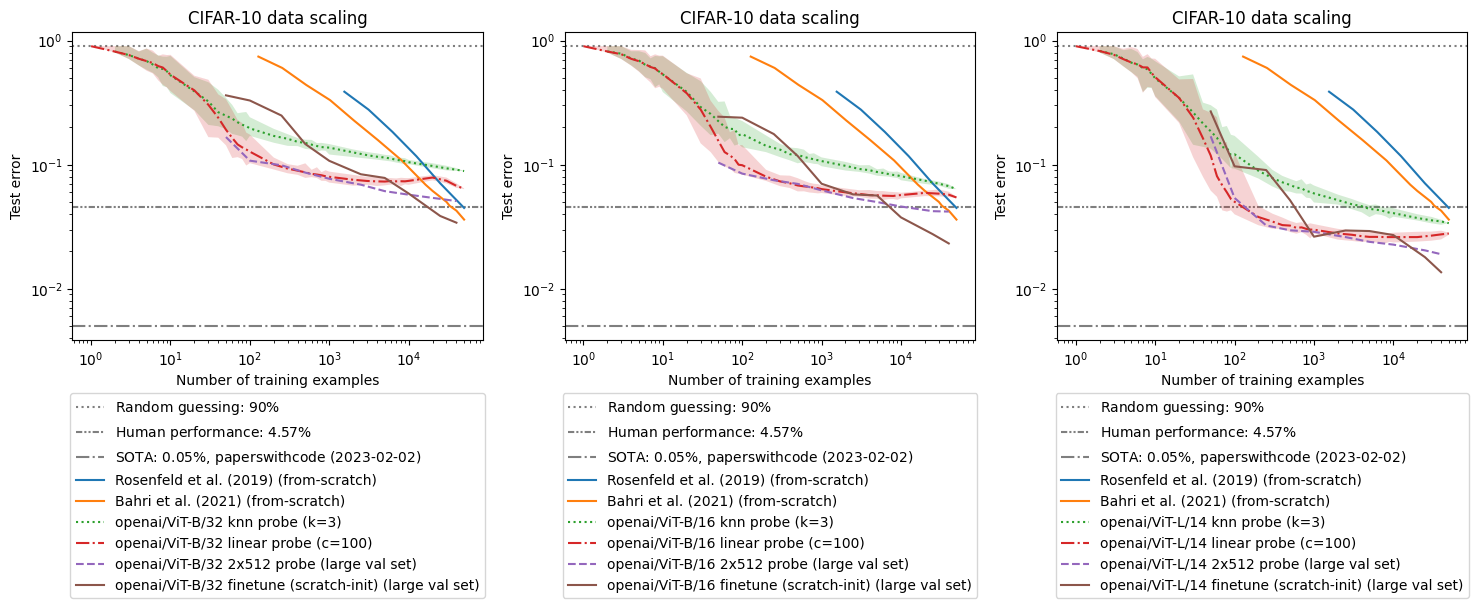

In [9]:
plt.figure(figsize=(18, 4))
for i, embedder_id in enumerate([
    "openai/ViT-B/32",
    "openai/ViT-B/16",
    "openai/ViT-L/14",
]):
    plt.subplot(1, 3, i + 1)
    plot_baselines()

    plt.plot(
        df_rosenfeld.n_train,
        df_rosenfeld.err,
        label="Rosenfeld et al. (2019) (from-scratch) ",
    )
    plt.plot(
        df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
    )

    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=f"{embedder_id} knn probe (k=3)",
        linestyle=":",
    )["ax"]
    prev_color = ax.lines[-1].get_color()
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
        linestyle="-."
    )

    for n_layers in [2]:
        for hidden_dim in [512]: #[512, 1024, 2048]:
            cdf = df_probe_scaling.query(
                "&".join(
                    (
                        f"embedder_cfg_id == @embedder_id",
                        f"fc_probe_cfg_n_layers == @n_layers",
                        f"fc_probe_cfg_hidden_dim == @hidden_dim",
                    )
                )
            ).sort_values("n_train").reset_index(drop=True)
            plt.plot(
                cdf.n_train - cdf.n_val_override,
                cdf.test_err,
                label=f"{embedder_id} {n_layers}x{hidden_dim} probe (large val set)",
                linestyle="--",
            )

    cdf = df_finetune.query(
            "&".join(
                (
                    "embedder_cfg_id == @embedder_id",
                    "~init_with_trained_linear_probe",
                )
            )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        label=f"{embedder_id} finetune (scratch-init) (large val set)",
    )

    plt.title(f"CIFAR-10 data scaling")

    plt.xscale("log")
    plt.yscale("log")
    # plt.yscale("symlog", linthresh=9e-3)
    # plt.ylim(-1e-3, 1.1)
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test error")

    # Plot legend underneath plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=1,
    )

### Freeze plots

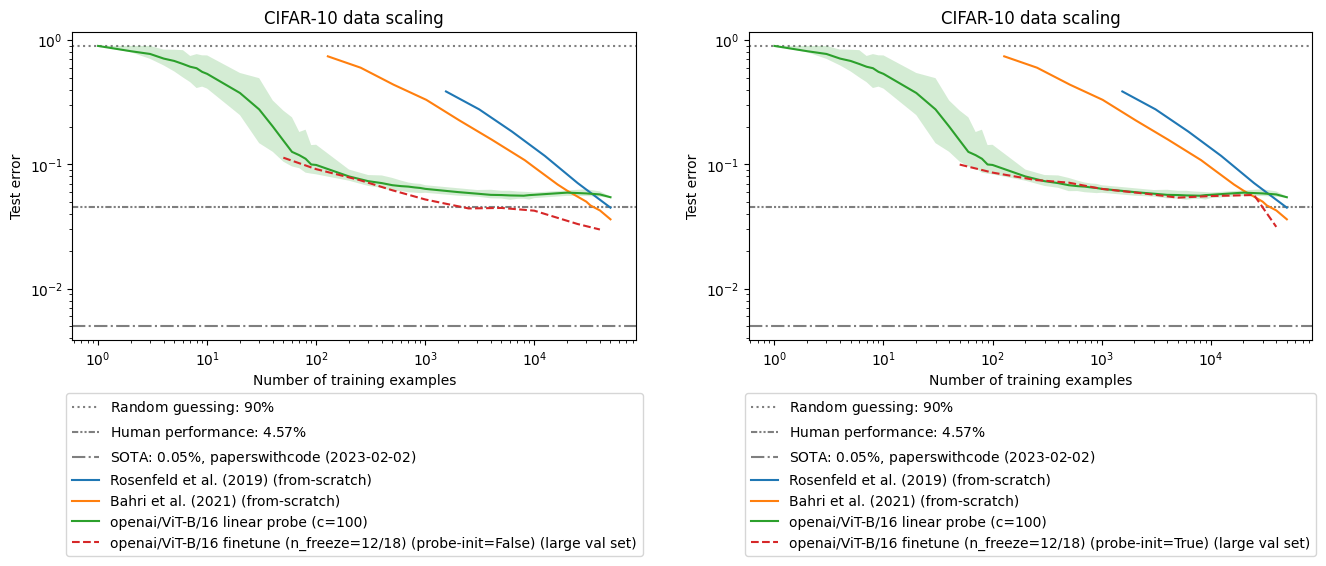

In [10]:
plt.figure(figsize=(16, 4))
for i, init_with_trained in enumerate((False, True)):
    plt.subplot(1, 2, i + 1)

    plot_baselines()
    plt.plot(
        df_rosenfeld.n_train,
        df_rosenfeld.err,
        label="Rosenfeld et al. (2019) (from-scratch) ",
    )
    plt.plot(
        df_bahri.n_train,
        df_bahri.err,
        label="Bahri et al. (2021) (from-scratch)",
    )

    embedder_id = "openai/ViT-B/16"

    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )["ax"]

    for n_freeze in [12]:#[0, 5, 10, 12, 15]:
        cdf = df_finetune_freeze.query(
            "&".join(
                (
                    "embedder_cfg_id == @embedder_id",
                    "init_with_trained_linear_probe"
                    if init_with_trained
                    else "~init_with_trained_linear_probe",
                    "n_layers_to_freeze == @n_freeze",
                )
            )
        ).sort_values("n_train")
        plt.plot(
            cdf.n_train - cdf.n_val_override,
            cdf.test_err,
            linestyle="--",
            label=f"{embedder_id} finetune ({n_freeze=}/18) (probe-init={init_with_trained}) (large val set)",
        )

    # cdf = df_finetune.query(
    #     "&".join(
    #         (
    #             "embedder_cfg_id == @embedder_id",
    #             "~init_with_trained_linear_probe",
    #         )
    #     )
    # ).sort_values("n_train")
    # plt.plot(
    #     cdf.n_train - cdf.n_val_override,
    #     cdf.test_err,
    #     linestyle=":",
    #     color=prev_color,
    #     label=f"{embedder_id} finetune (scratch-init) (large val set)",
    # )

    plt.title(f"CIFAR-10 data scaling")

    plt.xscale("log")
    plt.yscale("log")
    # plt.yscale("symlog", linthresh=9e-3)
    # plt.ylim(-1e-3, 1.1)
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test error")

    # Plot legend underneath plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=1,
    )

### Balanced data

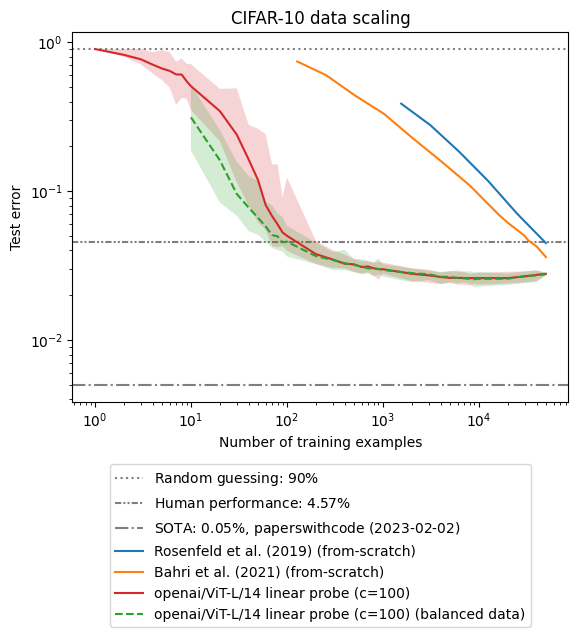

In [11]:
plot_baselines()
plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

embedder_id = "openai/ViT-L/14"
df["n_train10"] = df.n_train * 10
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label=f"{embedder_id} linear probe (c=100)",
    color="tab:red",
)
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == True",
    label=f"{embedder_id} linear probe (c=100) (balanced data)",
    gb_target="n_train10",
    linestyle="--",
    color="tab:green",
)

plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15));

### More plots

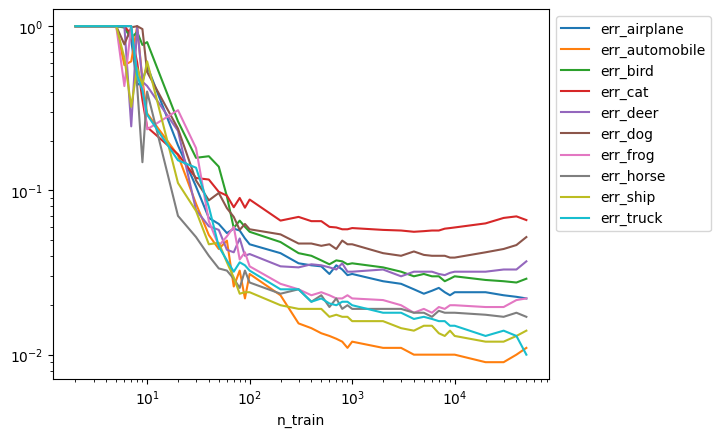

In [12]:
dataset_cfg = cifar10.CIFAR10()
embedder_id = "openai/ViT-L/14"
for i in range(10):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        target=f"err_{i}",
        label=f"err_{dataset_cfg.class_names[i]}",
        ci=0,
    )

plt.xscale("log")
plt.yscale("log")

# Legend on outside top right
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
);

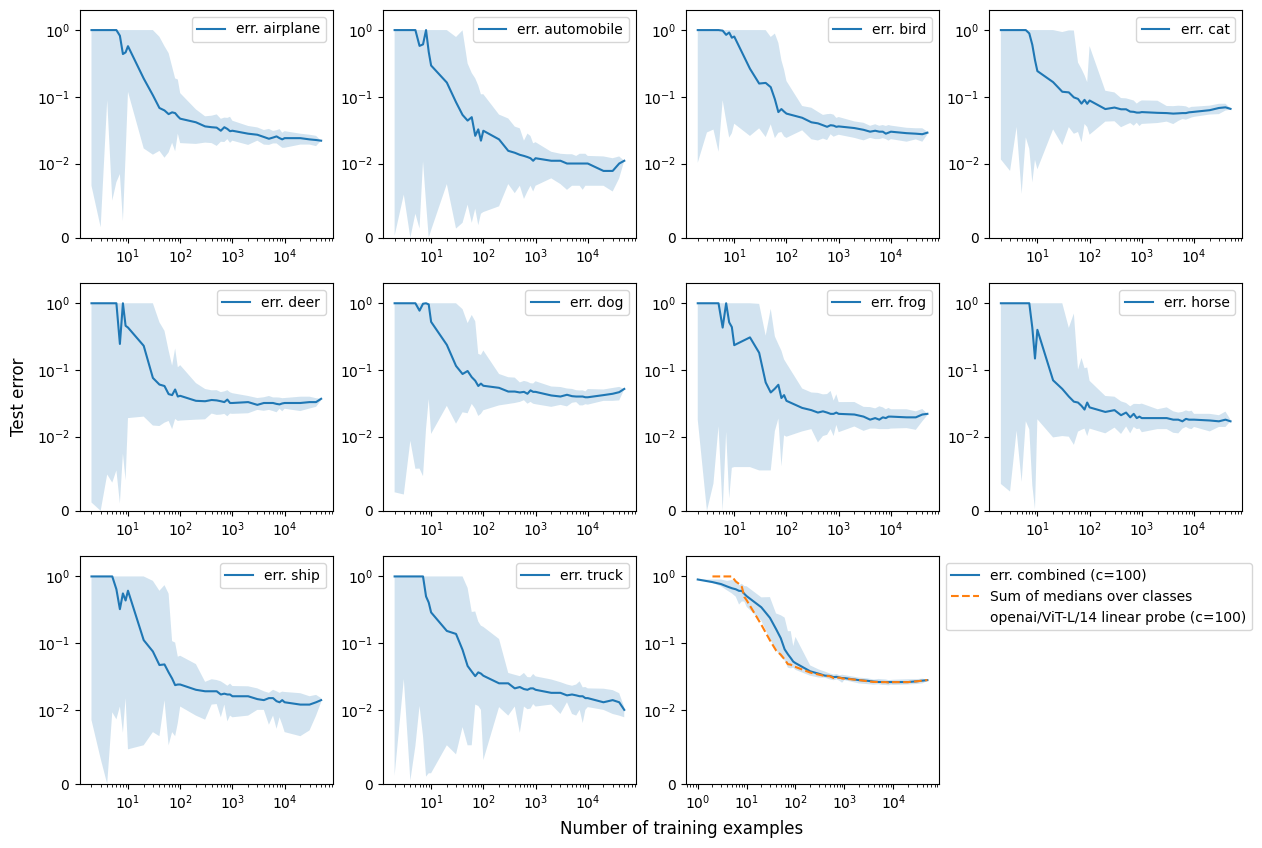

In [13]:
fig = plt.figure(figsize=(14, 9))
dataset_cfg = cifar10.CIFAR10()
df["n_train10"] = df.n_train * 10

gbs = []
# "openai/ViT-L/14"
# "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
# "hf/microsoft/beit-large-patch16-224"
per_class = False
embedder_id = "openai/ViT-L/14"
for i in range(10):
    plt.subplot(3, 4, i + 1)

    gb = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == {per_class}",
        target=f"err_{i}",
        label=f"err. {dataset_cfg.class_names[i]}",
        gb_target="n_train10" if per_class else "n_train",
        ci=0.95,
    )["gb"]
    gbs.append(gb)

    plt.xlabel(None)  #  type: ignore # Remove x-axis label
    plt.ylabel(None)  #  type: ignore # Remove y-axis label
    plt.xscale("log")
    plt.yscale("symlog", linthresh=1e-2)
    plt.ylim(0, 2)
    # Legend in bottom left
    plt.legend(loc="upper right")

plt.subplot(3, 4, 11)
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == {per_class}",
    label=f"err. combined (c=100)",
    gb_target="n_train10" if per_class else "n_train"
)
plt.plot(
    gbs[0].n_train.median(),
    sum(gb[f"err_{i}"].median() for i, gb in enumerate(gbs)) / 10,
    label="Sum of medians over classes",
    linestyle="--",
)
plt.xlabel(None)  #  type: ignore # Remove x-axis label
plt.ylabel(None)  #  type: ignore # Remove y-axis label
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-2)
plt.ylim(0, 2)
plt.plot([], [], alpha=0, label=f"{embedder_id} linear probe (c=100)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# plt.suptitle(f"Test error for {embedder_id} linear probe (c=100) ({per_class=})")
plt.subplots_adjust(top=0.93, left=0.07, bottom=0.07)  # Reduce suptitle space
fig.supxlabel("Number of training examples")
fig.supylabel("Test error");

### Data-pruning comparison plot (paper-ready)

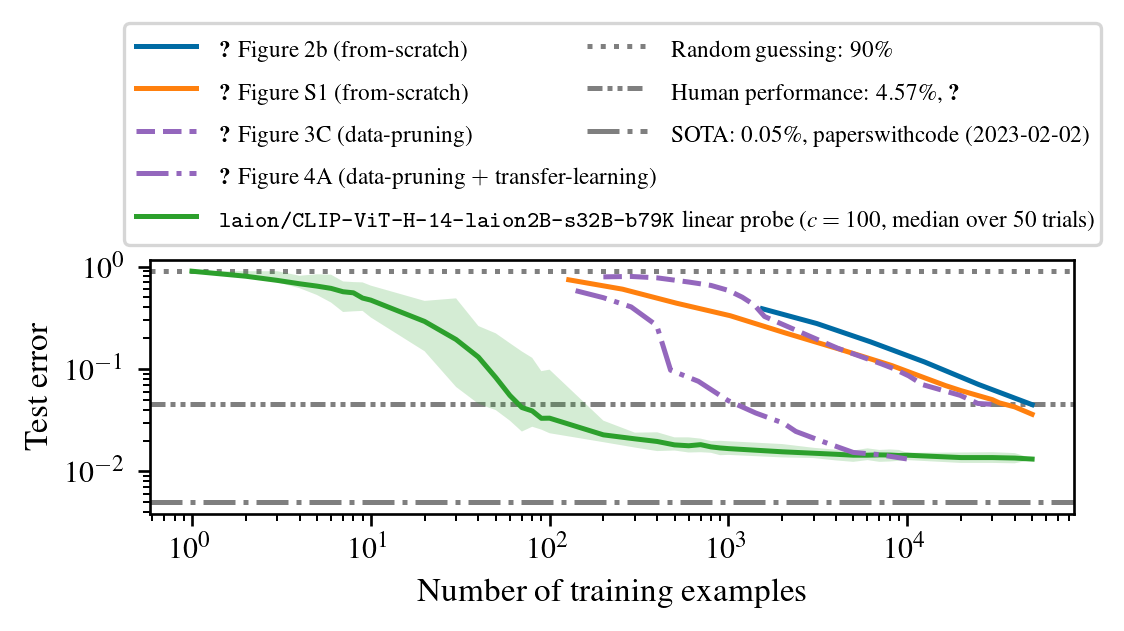

In [14]:
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsmath,amssymb,natbib}
""",
)
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb,natbib}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.25 * width))

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label=r"\scriptsize \citet{rosenfeld2019constructive} Figure 2b (from-scratch)",
    # label=r"\scriptsize Rosenfeld et al. (2019) Figure 2b (from-scratch)",
)
plt.plot(
    df_bahri.n_train,
    df_bahri.err,
    label=r"\scriptsize \citet{bahri2021explaining} Figure S1 (from-scratch)",
)
plt.plot(
    df_prune_scratch.n_train,
    df_prune_scratch.err,
    label=r"\scriptsize \citet{sorscher2022beyond} Figure 3C (data-pruning)",
    linestyle="--",
    color="tab:purple",
)
plt.plot(
    df_prune_transfer.n_train,
    df_prune_transfer.err,
    label=r"\scriptsize \citet{sorscher2022beyond} Figure 4A (data-pruning $+$ transfer-learning)",
    linestyle="-.",
    color="tab:purple",
    zorder=3,
)

for embedder_id in ("hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=rf"\scriptsize $\texttt{{{embedder_id[3:]}}}$ linear probe ($c = 100$, median over 50 trials)",
        ci=1,
        color="tab:green",
    )
    # Extra tildes needed for pgf bug
    # https://stackoverflow.com/q/62592222

plot_baselines(include_citation=True, label_prefix=r"\scriptsize ")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")
plt.plot([], [], label=r"\quad ", alpha=0)

# Plot legend on outside top right
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    columnspacing=-17,
)

# Add extra padding to plot on sides
plt.subplots_adjust(left=0.15, right=0.85)

plt.savefig("figures/data-pruning-comparison-cifar10.pgf", bbox_inches="tight")

### Cliff failures (i.e. cliffing doesn't always happen)

In [15]:
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "svhn"}},
        ]
    },
)

def get_svhn_data():
    dfs = process_map(
        get_df_from_run,
        [r.id for r in runs],
        [dict(r.config) for r in runs],
        [
            {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
            for r in runs
        ],
        max_workers=15,  # https://docs.wandb.ai/guides/track/limits
        tqdm_class=tqdm,
    )
    df = pd.concat(dfs, ignore_index=True)
    df["model"] = df["embedder_id"]
    df["model_type"] = df["embedder_id"].apply(
        lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
    )
    return df

svhn_df = get_svhn_data()

  0%|          | 0/450 [00:00<?, ?it/s]

In [16]:
svhn_df_finetune = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/finetune",
        filters={"tags": {"$in": ["svhn-finetune-v1"]}},
    )
)

svhn_df_probe_scaling = parse_finetune_runs(
    api.runs(
        f"data-frugal-learning/finetune",
        filters={"tags": {"$in": ["probe-scaling-svhn-v1"]}},
    )
)

svhn_df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/svhn/wpd-clean.csv")

svhn_df_prune = (
    pd.read_csv(GIT_ROOT / "data/sorscher-2022/svhn/wpd-clean.csv")
    .sort_values("n_train")
    .reset_index(drop=True)
)
svhn_df_prune["err"] = svhn_df_prune.res_err + svhn_df_prune.bayes_err

In [17]:
def svhn_plot_baselines():
    plt.axhline(
        0.9,
        color="k",
        linestyle=":",
        label="Random guessing",
        zorder=-10,
        alpha=0.5,
    )

    # http://ufldl.stanford.edu/housenumbers/nips2011_housenumbers.pdf
    plt.axhline(
        2 / 100,
        color="k",
        linestyle="-.",
        # label="Human performance (2%)",
        label="Human performance",
        zorder=-10,
        alpha=0.5,
    )

    # https://paperswithcode.com/sota/image-classification-on-svhn
    plt.axhline(
        0.99 / 100,
        color="k",
        linestyle="--",
        label="SOTA (paperswithcode)",
        zorder=-10,
        alpha=0.5,
    )

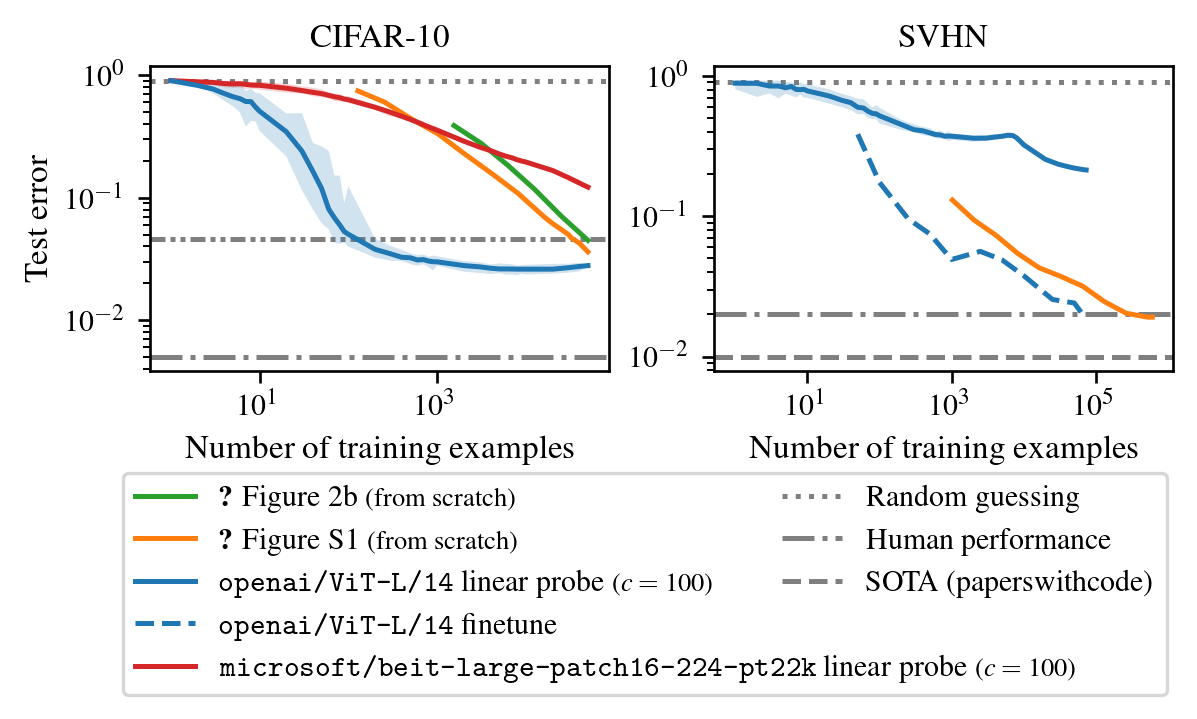

In [18]:
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsmath,amssymb,natbib}
""",
)
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb,natbib}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.3 * width))

plt.subplot(1, 2, 1)
# [plt.plot([], []) for _ in range(4)]
plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label=r"\citet{rosenfeld2019constructive} Figure 2b {\footnotesize (from scratch)}",
    color="tab:green",
)
plt.gca().set_prop_cycle(None)
plt.plot(
    df_bahri.n_train,
    df_bahri.err,
    label=r"\cite{bahri2021explaining} Figure S1 {\footnotesize (from scratch)}",
    color="tab:orange"
)

embedder_id = "hf/microsoft/beit-large-patch16-224-pt22k"
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label=rf"\texttt{{{embedder_id[3:]}}} linear probe {{\footnotesize ($c = 100$)}}",
    color="tab:red",
)

plt.gca().set_prop_cycle(None)
plt.plot([], [])
embedder_id = "openai/ViT-L/14"
# embedder_id = "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label=rf"\texttt{{{embedder_id}}} linear probe {{\footnotesize ($c = 100$)}}",
    color="tab:blue"
)

plot_baselines(include_labels=False)
plt.title(f"CIFAR-10")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

plt.subplot(1, 2, 2)
plt.plot(svhn_df_bahri.n_train, svhn_df_bahri.err, color="tab:orange")

embedder_id = "openai/ViT-L/14"
ax = plot_wandb_df(
    svhn_df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label="",
    dataset_id="svhn",
    color="tab:blue"
)["ax"]
prev_color = ax.lines[-1].get_color()

cdf = svhn_df_finetune.query(
    "&".join(
        (
            "embedder_cfg_id == @embedder_id",
            "~init_with_trained_linear_probe",
        )
    )
).sort_values("n_train")
plt.plot(
    cdf.n_train - cdf.n_val_override,
    cdf.test_err,
    linestyle="--",
    color=prev_color,
    label=rf"\texttt{{{embedder_id}}} finetune",
)

svhn_plot_baselines()
plt.title(f"SVHN")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.plot([], [], label=r"\quad ", alpha=0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
order = [0, 1, 3, 4, 2, 5, 6, 7, 8]
# order = [3, 5, 6, 7, 2, 4, 0, 1, 8]
lines = [lines[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(
    lines,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.11),
    ncols=2,
    columnspacing=-9.81, # Gravity
)
fig.subplots_adjust(wspace=0.23)

plt.savefig("figures/cliff-failures.pgf", bbox_inches="tight")

### CIFAR-10 transfer learning deep-dive

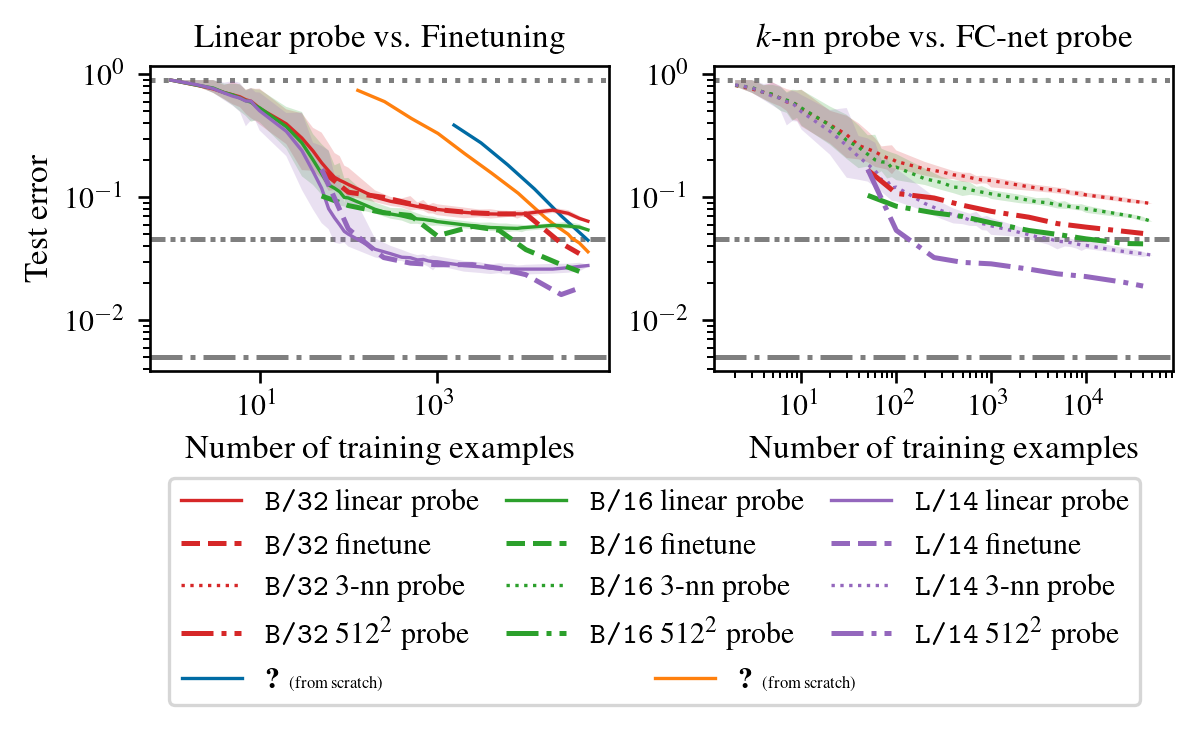

In [19]:
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsmath,amssymb,natbib}
""",
)
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb,natbib}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.3 * width))
colors = ["tab:red", "tab:green", "tab:purple"]
zipperino = list(
    zip(
        [
            "openai/ViT-B/32",
            "openai/ViT-B/16",
            "openai/ViT-L/14",
        ],
        colors,
    )
)

plt.subplot(1, 2, 1)
for embedder_id, color in zipperino:
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=rf"\texttt{{{embedder_id[-4:]}}} linear probe",
        color=color,
        linewidth=1,
    )

for embedder_id, color in zipperino:
    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        label=rf"\texttt{{{embedder_id[-4:]}}} finetune",
        linestyle="--",
        color=color,
    )

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label=r"\citet{rosenfeld2019constructive} {\tiny (from scratch)}",
    zorder=-5,
    linewidth=1,
)
plt.plot(
    df_bahri.n_train,
    df_bahri.err,
    label=r"\cite{bahri2021explaining} {\tiny (from scratch)}",
    zorder=-5,
    linewidth=1,
)

plot_baselines(include_labels=False)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")
plt.title("Linear probe vs. Finetuning")

plt.subplot(1, 2, 2)

for embedder_id, color in zipperino:
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=rf"\texttt{{{embedder_id[-4:]}}} $3$-nn probe",
        linestyle=":",
        color=color,
        linewidth=1,
    )

n_layers, hidden_dim = 2, 512
for embedder_id, color in zipperino:
    cdf = (
        df_probe_scaling.query(
            "&".join(
                (
                    f"embedder_cfg_id == @embedder_id",
                    f"fc_probe_cfg_n_layers == @n_layers",
                    f"fc_probe_cfg_hidden_dim == @hidden_dim",
                )
            )
        )
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        label=rf"\texttt{{{embedder_id[-4:]}}} ${hidden_dim}^{n_layers}$ probe",
        linestyle="-.",
        zorder=5,
        color=color,
    )

plot_baselines(include_labels=False)
plt.title("$k$-nn probe vs. FC-net probe")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.plot([], [], label=r"\quad ", alpha=0)
plt.plot([], [], label=r"\quad ", alpha=0)
plt.plot([], [], label=r"\quad ", alpha=0)

# # Plot legend underneath plot
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
order = [0, 3, 8, 11, 14, 1, 4, 9, 12, 15, 2, 5, 10, 13, 16]
fig.axes[0].legend(
    [lines[i] for i in order],
    [labels[i] for i in order],
    loc="upper center",
    bbox_to_anchor=(1.1, -0.3),
    ncols=3,
    columnspacing=0.9,
)
fig.subplots_adjust(wspace=0.23)

# Add another legend
fig.legend(
    lines[6:8],
    labels[6:8],
    ncols=2,
    # Don't show bounding box
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.129, -0.57),
    columnspacing=9,
)

plt.savefig("figures/transfer-deep-dive.pgf", bbox_inches="tight")

### SVHN scaling comparison

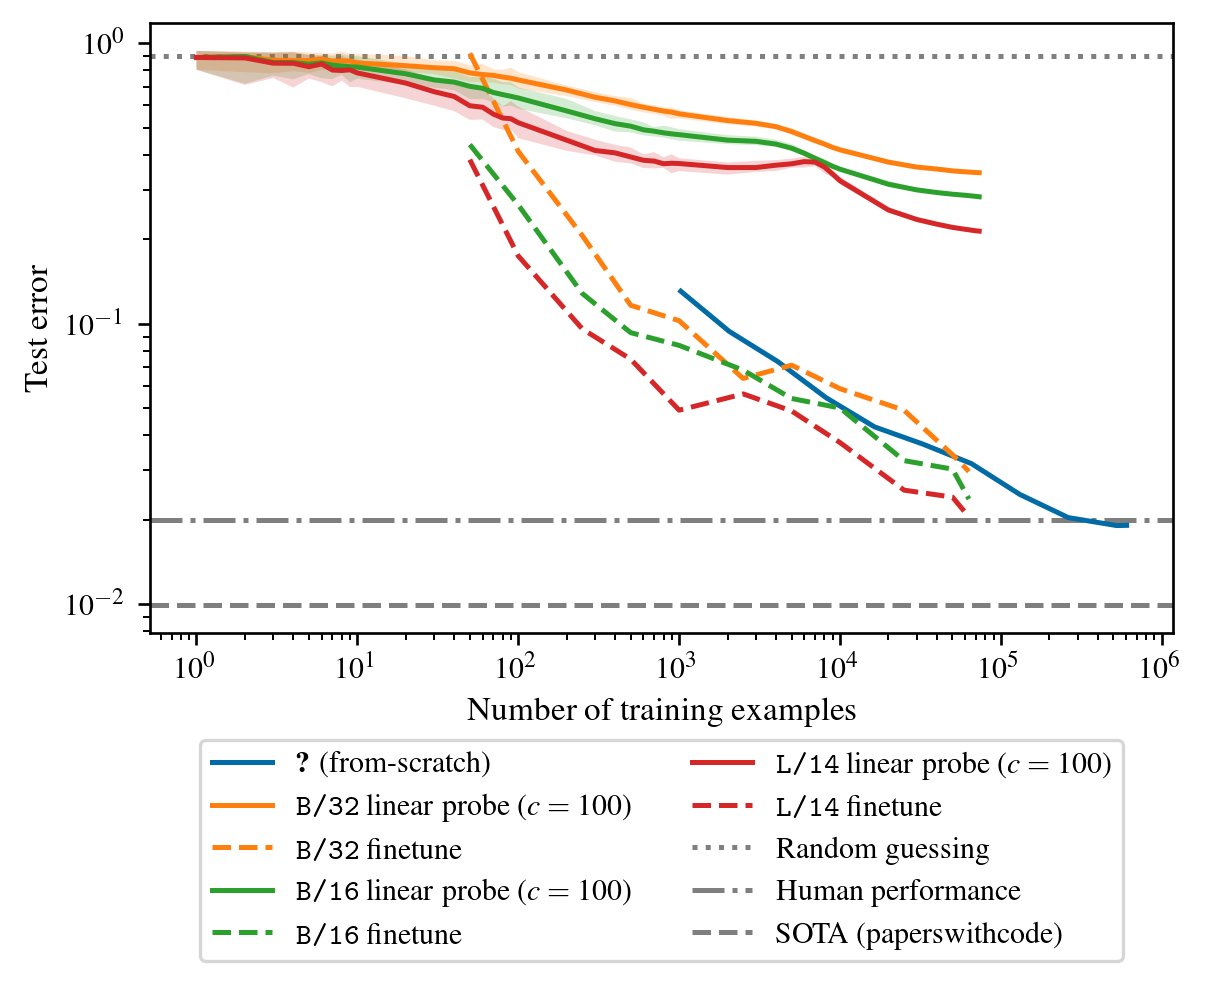

In [34]:
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsmath,amssymb,natbib}
""",
)
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb,natbib}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.6 * width))
colors = ["tab:orange", "tab:green", "tab:red"]
zipperino = list(
    zip(
        [
            "openai/ViT-B/32",
            "openai/ViT-B/16",
            "openai/ViT-L/14",
        ],
        colors,
    )
)

plt.plot(
    svhn_df_bahri.n_train, svhn_df_bahri.err,
    label=r"\cite{bahri2021explaining} (from-scratch)"
)

for embedder_id, color in zipperino:
    ax = plot_wandb_df(
        svhn_df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=rf"\texttt{{{embedder_id[-4:]}}} linear probe ($c = 100$)",
        dataset_id="svhn",
        color=color
    )["ax"]

    cdf = svhn_df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "~init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle="--",
        color=color,
        label=rf"\texttt{{{embedder_id[-4:]}}} finetune",
    )

svhn_plot_baselines()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
)

plt.savefig("figures/svhn-deep-dive.pgf", bbox_inches="tight")